In [1]:
#####################################################################################################################
#Developed by Jonathan Ojeda 8/1/2021 QAAFI UQ
# Code functionalities:
# In order to study the interactions between G and M under different climate conditions, climate zones
# can be created by kmeans clustering (Arthur and Vassilvitskii, 2007). The clustering is applied separately 
# to average mean daily temperature, sum solar radiation and rainfall during the crop growing season.

#Arthur, D., Vassilvitskii, S., 2007. k-means + +: the advantages of careful seeding.
#In: Proceedings of the Eighteenth Annual ACM-SIAM Symposium on Discrete
#Algorithms Society for Industrial and Applied Mathematics, New Orleans,
#Louisiana, pp. 1027–1035.
#####################################################################################################################

In [1]:
#import libraries
import random as rd
import os
import sqlite3
import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import dateutil
import pylab as py
import seaborn as sns
import scipy 
from scipy import stats
import sklearn.metrics
from numpy  import array
import glob
import functools
from functools import reduce
import matplotlib.ticker as ticker
import cartopy.io.shapereader as shpreader
import xarray as xr
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.ticker as mticker
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import matplotlib as mpl
from mpl_toolkits.axes_grid.inset_locator import (inset_axes, InsetPosition,
                                                  mark_inset)
from matplotlib.colors import LinearSegmentedColormap
from matplotlib import colors

from sklearn.cluster import KMeans

#Extend screen
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

<ipython-input-1-c2553a5dbab7>:28: MatplotlibDeprecationWarning: 
The mpl_toolkits.axes_grid module was deprecated in Matplotlib 2.1 and will be removed two minor releases later. Use mpl_toolkits.axes_grid1 and mpl_toolkits.axisartist, which provide the same functionality instead.
  from mpl_toolkits.axes_grid.inset_locator import (inset_axes, InsetPosition,


In [2]:
#Tool to minimize code and see only figures

from IPython.display import HTML
import random

def hide_toggle(for_next=False):
    this_cell = """$('div.cell.code_cell.rendered.selected')"""
    next_cell = this_cell + '.next()'

    toggle_text = 'Toggle show/hide'  # text shown on toggle link
    target_cell = this_cell  # target cell to control with toggle
    js_hide_current = ''  # bit of JS to permanently hide code in current cell (only when toggling next cell)

    if for_next:
        target_cell = next_cell
        toggle_text += ' next cell'
        js_hide_current = this_cell + '.find("div.input").hide();'

    js_f_name = 'code_toggle_{}'.format(str(random.randint(1,2**64)))

    html = """
        <script>
            function {f_name}() {{
                {cell_selector}.find('div.input').toggle();
            }}

            {js_hide_current}
        </script>

        <a href="javascript:{f_name}()">{toggle_text}</a>
    """.format(
        f_name=js_f_name,
        cell_selector=target_cell,
        js_hide_current=js_hide_current, 
        toggle_text=toggle_text
    )

    return HTML(html)

In [ ]:
#Create environments based on climate data
X1 = pd.read_csv(r'C:\Users\uqjojeda\Nextcloud\PURTERRA-A0131\2020\paper\data\newenv.csv')
X0 = X1.drop(['Unnamed: 0'], axis=1)
X = X0.set_index(['lat', 'lon'])
X

In [ ]:
#Create csv file with lat/lon combinations for a particular cover
#X.to_csv(r'C:\Users\uqjojeda\Nextcloud\PURTERRA-A0131\2020\paper\data\dfenv.csv')
X2 = X.loc[X['cropland'] > 0]
#X2.to_csv(r'C:\Users\uqjojeda\Nextcloud\PURTERRA-A0131\2020\paper\data\landuse.csv')

In [ ]:
#Check reduction in cropland taking out some specific percentage of non covered grids
crop0 = X.loc[X['cropland'] > 0] #1325/1765*100
print(1325/1765*100)
crop10 = X.loc[X['cropland'] > 10] #1075/1765*100
print(1075/1765*100)
crop20 = X.loc[X['cropland'] > 20] #929/1765*100
print(929/1765*100)
crop20.shape

In [3]:
#Create environments based on biomass data

#Read output from psims
data00 = xr.open_dataset(r'C:/Users/uqjojeda/Nextcloud/PURTERRA-A0131/2020/outputs/new/run019/output.nc4', decode_times=False) 

#Conver multidimendional frame to 2D frame
data = data00.to_dataframe()
data1 = data[data.biomass > 5789.0874] # removing failures #df.biomass.quantile(0.025)
data1.reset_index(drop=False, inplace=True)

df = pd.read_csv(r'C:\Users\uqjojeda\Nextcloud\PURTERRA-A0131\2020\Maps\SorghumMask\OutsideAreas.csv')
coordinate_list = [list(row) for row in df.values]

dropSet = {tuple(elem) for elem in coordinate_list}
# Creates a multi-index on letter/colour.
temp = data1.set_index(['lat', 'lon'])
# Keep all elements of the index except those in droplist.
temp = temp.loc[list(set(temp.index) - dropSet)]
# Reset index to get the original column layout.
df_dropped = temp.reset_index()
dfc = df_dropped[df_dropped.biomass != 0]

#Change name of column
dfc.rename(columns={'scen_new':'cultivar'}, inplace=True)

#Remove cells with 0% of cropland accordingly with AgMERRA dataset
landuse = pd.read_csv(r'C:\Users\uqjojeda\Nextcloud\PURTERRA-A0131\2020\paper\data\landuse.csv')
data3 = pd.merge(landuse, dfc, how ='inner', on =['lat','lon']) 

# data2 = data3.drop(['rain_a_x','radn_a_x','rain_b_x','radn_b_x','rain_c_x','radn_c_x','wind_a_x','hur_a_x','hurtmax_a_x','cropland_a_x',
#  'tmax_a_x', 'tmin_a_x', 'tmean_a_x', 'wind_b_x', 'hur_b_x', 'hurtmax_b_x', 'cropland_b_x', 'tmax_b_x', 'tmin_b_x',
#  'tmean_b_x','wind_c_x', 'hur_c_x', 'hurtmax_c_x', 'cropland_c_x', 'tmax_c_x', 'tmin_c_x', 'tmean_c_x', 'radn_x',
#  'rain_x', 'tmin_x', 'tmax_x', 'tmean_x', 'wind_x', 'hur_x', 'hurtmax_x', 'env_x', 'rain_a_y', 'radn_a_y',
#  'rain_b_y', 'radn_b_y', 'rain_c_y', 'radn_c_y', 'wind_a_y', 'hur_a_y', 'hurtmax_a_y', 'cropland_a_y', 'tmax_a_y',
#  'tmin_a_y', 'tmean_a_y', 'wind_b_y', 'hur_b_y','hurtmax_b_y', 'cropland_b_y', 'tmax_b_y', 'tmin_b_y', 'tmean_b_y',
#  'wind_c_y', 'hur_c_y', 'hurtmax_c_y', 'cropland_c_y', 'tmax_c_y', 'tmin_c_y', 'tmean_c_y', 'radn_y', 'rain_y',
#  'tmin_y', 'tmax_y', 'tmean_y', 'wind_y', 'hur_y', 'hurtmax_y', 'cropland_y', 'env_y'], axis=1)

df0 = data3.dropna()
df00=df0.replace(-99,np.nan).dropna(axis = 0, how = 'any')
df000 = df00[df00.irr != 2]
X0 = df000.groupby(['lat', 'lon'],as_index=False).mean()
X = X0.set_index(['lat', 'lon'])
X
#X.to_csv(r'C:\Users\uqjojeda\Nextcloud\PURTERRA-A0131\2020\paper\data\envGraeme.csv')

rain_a       radn_a      rain_b       radn_b      rain_c  \
lat   lon                                                                    
26.25 -98.25  101.451232  1485.068086  102.070737  1656.519444  168.582482   
      -97.75  120.379988  1457.226050  116.056331  1608.712125  218.881505   
      -80.25  302.262014  1552.730923  445.093349  1409.881997  437.423147   
26.75 -99.25  102.039210  1492.454966  109.050728  1652.926605  152.524321   
      -98.75  103.710020  1488.771635  107.401054  1669.688478  171.812522   
...                  ...          ...         ...          ...         ...   
48.75 -96.25  121.202056  1351.494201  196.227977  1483.297121  128.369978   
      -95.75  127.102852  1335.352554  210.105222  1458.713318  136.934414   
      -94.75  135.401398  1329.988231  220.607078  1449.063847  160.246045   
      -94.25  138.773441  1330.767344  230.377439  1444.372496  174.353169   
      -93.75  144.157204  1328.623273  229.370940  1425.817929  175.696677   

                   radn_c    wind_a      hur_a  hurtmax_a  cropland_a  ...  \
lat   lon                                                              ...   
26.25 -98.25  1288.318815  3.313698  69.106140  48.211823        13.0  ...   
      -97.75  1259.478545  3.635881  69.832310  50.229427        51.0  ...   
      -80.25  1216.124164  3.184109  73.627110  57.786846         4.0  ...   
26.75 -99.25  1281.923292  3.293787  62.682100  43.158440         9.0  ...   
      -98.75  1289.996954  3.255952  68.902336  47.898296         8.0  ...   
...                   ...       ...        ...        ...         ...  ...   
48.75 -96.25   844.847751  2.945820  57.753464  36.652462        51.0  ...   
      -95.75   829.653565  2.660518  58.803204  37.618526        62.0  ...   
      -94.75   826.623419  2.331531  61.096990  40.294480        10.0  ...   
      -94.25   822.739236  1.471831  58.679497  38.873978        52.0  ...   
      -93.75   808.187855  0.964755  57.775917  38.429394        35.0  ...   

               sw40_80  sw80_harv  sw_stress_expan  sw_stress_photo  \
lat   lon                                                             
26.25 -98.25  0.651816   0.267429         0.525061         0.574020   
      -97.75  0.708705   0.396574         0.602393         0.647033   
      -80.25  0.999575   1.000000         0.980167         0.980283   
26.75 -99.25  0.558528   0.305417         0.625042         0.677125   
      -98.75  0.671096   0.310173         0.610288         0.657673   
...                ...        ...              ...              ...   
48.75 -96.25  0.989113   0.996873         0.972845         0.974732   
      -95.75  0.993591   0.998773         0.974758         0.975924   
      -94.75  0.998494   0.999531         0.980543         0.980914   
      -94.25  0.999824   0.999941         0.982221         0.982265   
      -93.75  0.999968   0.999968         0.982323         0.982355   

              temp40DAS  temp80DAS   tempHarv    tp0_40   tp40_80  tp80_harv  
lat   lon                                                                     
26.25 -98.25  27.263979  29.860205  30.704449  0.999673  1.000000   1.000000  
      -97.75  27.435524  29.633459  30.143967  0.999738  1.000000   1.000000  
      -80.25  25.945366  27.805599  28.530317  0.999567  1.000000   1.000000  
26.75 -99.25  28.625500  30.776278  31.335180  0.999722  0.999722   0.999667  
      -98.75  27.362616  29.733461  30.622711  0.999538  1.000000   1.000000  
...                 ...        ...        ...       ...       ...        ...  
48.75 -96.25  18.707451  19.572479  14.356408  0.832000  0.872099   0.533592  
      -95.75  18.388121  19.061893  13.811121  0.815727  0.853576   0.496879  
      -94.75  18.317184  19.184555  14.042988  0.811481  0.860815   0.508321  
      -94.25  18.002354  19.065310  14.306382  0.789324  0.857206   0.524250  
      -93.75  17.734711  18.827145  13.921678  0.773484  0.842516   0.500194  

[1325 rows x 80 columns]

In [4]:
#Calculate clusters using k-means

kmeans = KMeans(n_clusters=3, n_init=200, algorithm='elkan') 

y = kmeans.fit_predict(X[['ri0_40','ri40_80','ri80_harv','sw0_40','sw40_80','sw80_harv','tp0_40','tp40_80','tp80_harv']])

X['env'] = y
#print(X)

In [5]:
#Calculate means and SD for Rad, Rain and Temp in each environment
mean_env = X.groupby(['env'])[['ri0_40','ri40_80','ri80_harv','sw0_40','sw40_80','sw80_harv','tp0_40','tp40_80','tp80_harv',
                              'temp40DAS','temp80DAS','tempHarv','rain40DAS','rain80DAS','rainHarv','rad40DAS','rad80DAS','radHarv']].mean().round(decimals=2)
#mean_env.rename(columns={'RadiationIn':'RadiationIn_m','TempIn':'TempIn_m','RainIn':'RainIn_m'}, inplace=True)

sd_env = X.groupby(['env'])[['ri0_40','ri40_80','ri80_harv','sw0_40','sw40_80','sw80_harv','tp0_40','tp40_80','tp80_harv',
                             'temp40DAS','temp80DAS','tempHarv','rain40DAS','rain80DAS','rainHarv','rad40DAS','rad80DAS','radHarv']].std().round(decimals=2)
#sd_env.rename(columns={'RadiationIn':'RadiationIn_sd','TempIn':'TempIn_sd','RainIn':'RainIn_sd'}, inplace=True)
#sd_env

envs = pd.concat([mean_env, sd_env], axis=1)
#envs.to_csv(r'C:\Users\uqjojeda\Nextcloud\PURTERRA-A0131\2020\paper\data\envsFinal.csv')

In [ ]:
#X.to_csv(r'C:\Users\uqjojeda\Nextcloud\PURTERRA-A0131\2020\paper\data\KMEANS.csv')

In [6]:
#Convert dataframe to xarray to plot
df_env = X.to_xarray()
df_env

<xarray.Dataset>
Dimensions:          (lat: 46, lon: 64)
Coordinates:
  * lat              (lat) float64 26.25 26.75 27.25 27.75 ... 47.75 48.25 48.75
  * lon              (lon) float64 -103.8 -103.2 -102.8 ... -73.25 -72.75 -72.25
Data variables:
    rain_a           (lat, lon) float64 nan nan nan nan nan ... nan nan nan nan
    radn_a           (lat, lon) float64 nan nan nan nan nan ... nan nan nan nan
    rain_b           (lat, lon) float64 nan nan nan nan nan ... nan nan nan nan
    radn_b           (lat, lon) float64 nan nan nan nan nan ... nan nan nan nan
    rain_c           (lat, lon) float64 nan nan nan nan nan ... nan nan nan nan
    radn_c           (lat, lon) float64 nan nan nan nan nan ... nan nan nan nan
    wind_a           (lat, lon) float64 nan nan nan nan nan ... nan nan nan nan
    hur_a            (lat, lon) float64 nan nan nan nan nan ... nan nan nan nan
    hurtmax_a        (lat, lon) float64 nan nan nan nan nan ... nan nan nan nan
    cropland_a       (lat, lon) float64 nan nan nan nan nan ... nan nan nan nan
    tmax_a           (lat, lon) float64 nan nan nan nan nan ... nan nan nan nan
    tmin_a           (lat, lon) float64 nan nan nan nan nan ... nan nan nan nan
    tmean_a          (lat, lon) float64 nan nan nan nan nan ... nan nan nan nan
    wind_b           (lat, lon) float64 nan nan nan nan nan ... nan nan nan nan
    hur_b            (lat, lon) float64 nan nan nan nan nan ... nan nan nan nan
    hurtmax_b        (lat, lon) float64 nan nan nan nan nan ... nan nan nan nan
    cropland_b       (lat, lon) float64 nan nan nan nan nan ... nan nan nan nan
    tmax_b           (lat, lon) float64 nan nan nan nan nan ... nan nan nan nan
    tmin_b           (lat, lon) float64 nan nan nan nan nan ... nan nan nan nan
    tmean_b          (lat, lon) float64 nan nan nan nan nan ... nan nan nan nan
    wind_c           (lat, lon) float64 nan nan nan nan nan ... nan nan nan nan
    hur_c            (lat, lon) float64 nan nan nan nan nan ... nan nan nan nan
    hurtmax_c        (lat, lon) float64 nan nan nan nan nan ... nan nan nan nan
    cropland_c       (lat, lon) float64 nan nan nan nan nan ... nan nan nan nan
    tmax_c           (lat, lon) float64 nan nan nan nan nan ... nan nan nan nan
    tmin_c           (lat, lon) float64 nan nan nan nan nan ... nan nan nan nan
    tmean_c          (lat, lon) float64 nan nan nan nan nan ... nan nan nan nan
    radn             (lat, lon) float64 nan nan nan nan nan ... nan nan nan nan
    rain             (lat, lon) float64 nan nan nan nan nan ... nan nan nan nan
    tmin             (lat, lon) float64 nan nan nan nan nan ... nan nan nan nan
    tmax             (lat, lon) float64 nan nan nan nan nan ... nan nan nan nan
    tmean            (lat, lon) float64 nan nan nan nan nan ... nan nan nan nan
    wind             (lat, lon) float64 nan nan nan nan nan ... nan nan nan nan
    hur              (lat, lon) float64 nan nan nan nan nan ... nan nan nan nan
    hurtmax          (lat, lon) float64 nan nan nan nan nan ... nan nan nan nan
    cropland         (lat, lon) float64 nan nan nan nan nan ... nan nan nan nan
    irr              (lat, lon) float64 nan nan nan nan nan ... nan nan nan nan
    cultivar         (lat, lon) float64 nan nan nan nan nan ... nan nan nan nan
    time             (lat, lon) float64 nan nan nan nan nan ... nan nan nan nan
    DOY              (lat, lon) float32 nan nan nan nan nan ... nan nan nan nan
    DaysAfterSowing  (lat, lon) float32 nan nan nan nan nan ... nan nan nan nan
    ESW1av           (lat, lon) float32 nan nan nan nan nan ... nan nan nan nan
    FloweringDAS     (lat, lon) float32 nan nan nan nan nan ... nan nan nan nan
    IrrigationIn     (lat, lon) float32 nan nan nan nan nan ... nan nan nan nan
    LeafNo           (lat, lon) float32 nan nan nan nan nan ... nan nan nan nan
    MaxLAI           (lat, lon) float32 nan nan nan nan nan ... nan nan nan nan
    N_stress_expan   (lat, lon) float32 nan nan nan nan nan ... nan nan 

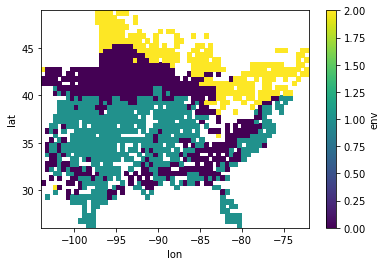

In [10]:
df_env.env[0:,0:].plot(yincrease=True, x='lon', y='lat')

In [11]:
#Create name for environments
X.loc[X.env == 1, 'env_name'] = "High"
X.loc[X.env == 0, 'env_name'] = "Mid"
X.loc[X.env == 2, 'env_name'] = "Low"

#X.to_csv(r'C:\Users\uqjojeda\Nextcloud\PURTERRA-A0131\2020\paper\data\dfenv2.csv')

In [8]:
X.columns

Index(['rain_a', 'radn_a', 'rain_b', 'radn_b', 'rain_c', 'radn_c', 'wind_a',
       'hur_a', 'hurtmax_a', 'cropland_a', 'tmax_a', 'tmin_a', 'tmean_a',
       'wind_b', 'hur_b', 'hurtmax_b', 'cropland_b', 'tmax_b', 'tmin_b',
       'tmean_b', 'wind_c', 'hur_c', 'hurtmax_c', 'cropland_c', 'tmax_c',
       'tmin_c', 'tmean_c', 'radn', 'rain', 'tmin', 'tmax', 'tmean', 'wind',
       'hur', 'hurtmax', 'cropland', 'irr', 'cultivar', 'time', 'DOY',
       'DaysAfterSowing', 'ESW1av', 'FloweringDAS', 'IrrigationIn', 'LeafNo',
       'MaxLAI', 'N_stress_expan', 'N_stress_photo', 'PAWC', 'RadiationIn',
       'RainIn', 'TempIn', 'WU', 'aMaxT', 'aMinT', 'actual_ET', 'biomass',
       'planting_date', 'potential_ET', 'rad40DAS', 'rad80DAS', 'radHarv',
       'rain40DAS', 'rain80DAS', 'rainHarv', 'ri0_40', 'ri40_80', 'ri80_harv',
       'scen', 'sw0_40', 'sw40_80', 'sw80_harv', 'sw_stress_expan',
       'sw_stress_photo', 'temp40DAS', 'temp80DAS', 'tempHarv', 'tp0_40',
       'tp40_80', 'tp80_harv'

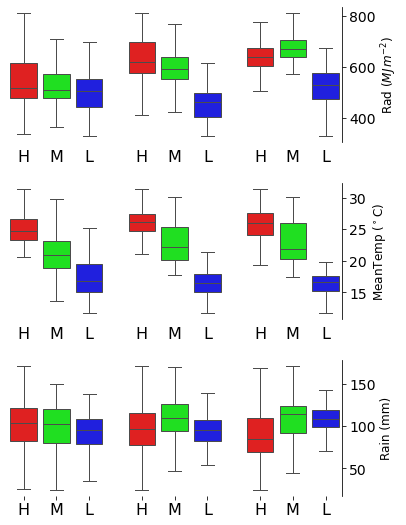

In [12]:
color_dict = dict({'High': '#ff0101','Mid':'#00ff01','Low':'#0000fe'})

fig= plt.figure(figsize=(6,9))

plt.subplot(3, 3, 1)
ax=sns.boxplot(x="env_name", order=['High','Mid','Low'], y="rad40DAS", data=X, width=0.8,
            linewidth=1, showfliers = False, palette=color_dict)
plt.ylabel('', fontsize =12)
plt.xlabel('', fontsize =12)
ax.yaxis.tick_right()
ax.yaxis.set_tick_params(labelsize=14)
ax.xaxis.set_tick_params(labelsize=16)
ax.yaxis.set_major_locator(ticker.MultipleLocator(200))
ax.yaxis.set_major_formatter(ticker.ScalarFormatter())
plt.tick_params(axis='x',bottom=False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.tick_params(left=False, bottom=False, right=False)

pos   = [0,1,2]
label = ['H','M','L']
ax.set_xticks(pos)
ax.set_xticklabels(label)

plt.subplot(3, 3, 2)
ax=sns.boxplot(x="env_name", order=['High','Mid','Low'], y="rad80DAS", data=X, width=0.8,
            linewidth=1, showfliers = False, palette=color_dict)
plt.ylabel('', fontsize =12)
plt.xlabel('', fontsize =12)
ax.yaxis.tick_right()
ax.yaxis.set_label_position("right")
ax.yaxis.set_tick_params(labelsize=14)
ax.xaxis.set_tick_params(labelsize=16)
ax.yaxis.set_major_locator(ticker.MultipleLocator(200))
ax.yaxis.set_major_formatter(ticker.ScalarFormatter())
plt.tick_params(axis='x',bottom=False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.tick_params(left=False, bottom=False, right=False)

pos   = [0,1,2]
label = ['H','M','L']
ax.set_xticks(pos)
ax.set_xticklabels(label)

plt.subplot(3, 3, 3)
ax=sns.boxplot(x="env_name", order=['High','Mid','Low'], y="radHarv", data=X, width=0.8,
            linewidth=1, showfliers = False, palette=color_dict)
plt.ylabel('Rad ($MJ\,m^{-2}$)', fontsize =12)
plt.xlabel('', fontsize =12)
ax.yaxis.tick_right()
ax.yaxis.set_label_position("right")
ax.yaxis.set_tick_params(labelsize=14)
ax.xaxis.set_tick_params(labelsize=16)
ax.yaxis.set_major_locator(ticker.MultipleLocator(200))
ax.yaxis.set_major_formatter(ticker.ScalarFormatter())
plt.tick_params(axis='x',bottom=False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.set_xticklabels([])
ax.tick_params(bottom=False)

pos   = [0,1,2]
label = ['H','M','L']
ax.set_xticks(pos)
ax.set_xticklabels(label)

plt.subplot(3, 3, 4)
ax=sns.boxplot(x="env_name", order=['High','Mid','Low'], y="temp40DAS", data=X, width=0.8,
            linewidth=1, showfliers = False, palette=color_dict)
plt.ylabel('', fontsize =12)
plt.xlabel('', fontsize =12)
ax.yaxis.tick_right()
ax.yaxis.set_label_position("right")
ax.yaxis.set_tick_params(labelsize=14)
ax.xaxis.set_tick_params(labelsize=16)
ax.yaxis.set_major_locator(ticker.MultipleLocator(5))
ax.yaxis.set_major_formatter(ticker.ScalarFormatter())
plt.tick_params(axis='x',bottom=False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.tick_params(left=False, bottom=False, right=False)

pos   = [0,1,2]
label = ['H','M','L']
ax.set_xticks(pos)
ax.set_xticklabels(label)

plt.subplot(3, 3, 5)
ax=sns.boxplot(x="env_name", order=['High','Mid','Low'], y="temp80DAS", data=X, width=0.8,
            linewidth=1, showfliers = False, palette=color_dict)
plt.ylabel('', fontsize =12)
plt.xlabel('', fontsize =12)
ax.yaxis.tick_right()
ax.yaxis.set_label_position("right")
ax.yaxis.set_tick_params(labelsize=14)
ax.xaxis.set_tick_params(labelsize=16)
ax.yaxis.set_major_locator(ticker.MultipleLocator(5))
ax.yaxis.set_major_formatter(ticker.ScalarFormatter())
plt.tick_params(axis='x',bottom=False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.tick_params(left=False, bottom=False, right=False)

pos   = [0,1,2]
label = ['H','M','L']
ax.set_xticks(pos)
ax.set_xticklabels(label)

plt.subplot(3, 3, 6)
ax=sns.boxplot(x="env_name", order=['High','Mid','Low'], y="tempHarv", data=X, width=0.8,
            linewidth=1, showfliers = False, palette=color_dict)
plt.ylabel('MeanTemp ($^\circ$C)', fontsize =12)
plt.xlabel('', fontsize =12)
ax.yaxis.tick_right()
ax.yaxis.set_label_position("right")
ax.yaxis.set_tick_params(labelsize=14)
ax.xaxis.set_tick_params(labelsize=16)
ax.yaxis.set_major_locator(ticker.MultipleLocator(5))
ax.yaxis.set_major_formatter(ticker.ScalarFormatter())
plt.tick_params(axis='x',bottom=False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.set_xticklabels([])
ax.tick_params(bottom=False)

pos   = [0,1,2]
label = ['H','M','L']
ax.set_xticks(pos)
ax.set_xticklabels(label)

plt.subplot(3, 3, 7)
ax=sns.boxplot(x="env_name", order=['High','Mid','Low'], y="rain40DAS", data=X, width=0.8,
            linewidth=1, showfliers = False, palette=color_dict)
plt.ylabel('', fontsize =12)
plt.xlabel('')
ax.yaxis.tick_right()
ax.yaxis.set_label_position("right")
ax.yaxis.set_tick_params(labelsize=14)
ax.xaxis.set_tick_params(labelsize=16)
ax.yaxis.set_major_locator(ticker.MultipleLocator(50))
ax.yaxis.set_major_formatter(ticker.ScalarFormatter())
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.tick_params(left=False, right=False)

pos   = [0,1,2]
label = ['H','M','L']
ax.set_xticks(pos)
ax.set_xticklabels(label)

plt.subplot(3, 3, 8)
ax=sns.boxplot(x="env_name", order=['High','Mid','Low'], y="rain80DAS", data=X, width=0.8,
            linewidth=1, showfliers = False, palette=color_dict)
plt.ylabel('', fontsize =12)
plt.xlabel('')
ax.yaxis.tick_right()
ax.yaxis.set_label_position("right")
ax.yaxis.set_tick_params(labelsize=14)
ax.xaxis.set_tick_params(labelsize=16)
ax.yaxis.set_major_locator(ticker.MultipleLocator(50))
ax.yaxis.set_major_formatter(ticker.ScalarFormatter())
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.tick_params(left=False, right=False)

pos   = [0,1,2]
label = ['H','M','L']
ax.set_xticks(pos)
ax.set_xticklabels(label)

plt.subplot(3, 3, 9)
ax=sns.boxplot(x="env_name", order=['High','Mid','Low'], y="rainHarv", data=X, width=0.8,
            linewidth=1, showfliers = False, palette=color_dict)
plt.ylabel('Rain (mm)', fontsize =12)
plt.xlabel('')
ax.yaxis.tick_right()
ax.yaxis.set_label_position("right")
ax.yaxis.set_tick_params(labelsize=14)
ax.xaxis.set_tick_params(labelsize=16)
ax.yaxis.set_major_locator(ticker.MultipleLocator(50))
ax.yaxis.set_major_formatter(ticker.ScalarFormatter())
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)

pos   = [0,1,2]
label = ['H','M','L']
ax.set_xticks(pos)
ax.set_xticklabels(label)

plt.subplots_adjust(wspace=0.2, hspace=0.3)

#plt.savefig(r'C:\Users\uqjojeda\Nextcloud\PURTERRA-A0131\2020\paper\figs\envs_clim.png', dpi=600,bbox_inches='tight')

hide_toggle()

<ipython-input-15-3321e6e9900b>:75: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
  ax.outline_patch.set_visible(False)


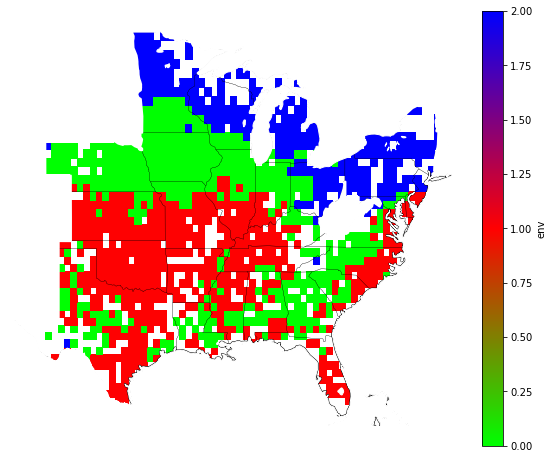

In [15]:
#Plotting map with environmental zones
fig, ax = plt.subplots(1, 1, subplot_kw=dict(projection=ccrs.Mercator(central_longitude=-95)),figsize=(10,8))

colors = ['#00ff01','#ff0101','#0000fe']
cmap_name = 'my_list'
cm = LinearSegmentedColormap.from_list(cmap_name, colors)

p=df_env.env.plot(x='lon', y='lat', transform=ccrs.PlateCarree(central_longitude=0),
robust=True, cmap=cm, add_colorbar=True, zorder=1, vmin=0, vmax=2)

def area(ax, iso, clr) :
    shp = shpreader.natural_earth(resolution='10m',category='cultural',name='admin_0_countries')
    reader = shpreader.Reader(shp)
    for n in reader.records() :
        if n.attributes['ADM0_A3'] == iso: 
            ax.add_geometries(n.geometry, ccrs.PlateCarree(), facecolor=clr,
                              alpha = 1.00, linewidth =3, edgecolor = "white",
                              label=n.attributes['ADM0_A3']) 
    return ax

iso3 = ['CAN', 'MEX']

def area2(ax, iso, clr, z) :
    
    shp = shpreader.natural_earth(resolution='110m',category='cultural', name='admin_1_states_provinces_lakes_shp')
    reader = shpreader.Reader(shp)
    for n in reader.records() :
        if n.attributes['postal'] == iso: 
            try:
                ax.add_geometries(n.geometry, ccrs.PlateCarree(), facecolor=clr, zorder=z,
                                  alpha = 1.00, linewidth =2, edgecolor = "white",
                                  label=n.attributes['postal']) 
            except Exception as e:
                #print(e)
                import shapely.wkt as wkt
                from shapely.geometry import MultiPolygon
                list_str_polygons = [str(n.geometry)]
                c = MultiPolygon(map(wkt.loads, list_str_polygons))
                ax.add_geometries(c, ccrs.PlateCarree(), facecolor=clr,
                                  alpha = 1.00, linewidth =2, edgecolor = "white",
                                  label=n.attributes['postal']) 
    return ax

iso4 = ['NM','CO','WY','ND','SD', 'WV', 'MT','VT','NH','MA','RI','CT']

gl=ax.gridlines(crs=ccrs.PlateCarree(), linewidth=0.01, color='w', alpha=0, linestyle='-', 
                draw_labels=False,dms=True, x_inline=False, y_inline=False)
#ax.coastlines(color='k',linewidth=0.3, zorder=4)
ax.add_feature(cfeature.COASTLINE, edgecolor = "k", linewidth=2)
ax.add_feature(cfeature.STATES, edgecolor = "k", linewidth=0.2, zorder=1)
ax.add_feature(cfeature.OCEAN, color='white', zorder=2)
ax.add_feature(cfeature.LAKES, color='white', zorder=1.5)
ax.add_feature(cfeature.BORDERS, edgecolor = "k", color='k', linewidth=2)
ax.set_extent([-107, -72, 24.5, 49], crs=ccrs.PlateCarree())
gl.xlabels_top = False
gl.ylabels_right = False

gl.xlocator = mticker.FixedLocator([-100, -90, -80])
gl.ylocator = mticker.FixedLocator([30, 35,40, 45])
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlabel_style = {'size': 10, 'color': 'k'}
gl.ylabel_style = {'size': 10, 'color': 'k'}

for value in iso4 :
    area2(ax, value, "white", 4)

area2(ax, value, "white", 4)

for value in iso3 :
    area(ax, value, "white")

area(ax, value, "white")

ax.outline_patch.set_visible(False)

# build and plot coordinates onto map
stations = pd.read_csv(r'C:\Users\uqjojeda\Nextcloud\PURTERRA-A0131\2020\Validation\Python\all-stations.csv')
x = stations.lon
y = stations.lat
#ax.scatter(stations.lon, stations.lat, marker='o', color='k', transform=ccrs.PlateCarree(),zorder=2, s=200)

#plt.savefig(r'C:\Users\uqjojeda\Nextcloud\PURTERRA-A0131\2020\paper\figs\MAPbiomass.png', dpi=600, bbox_inches='tight', pad_inches=0)
hide_toggle()

In [14]:
#Write nc file on disk
#df_env.to_netcdf(r'C:\Users\uqjojeda\Nextcloud\PURTERRA-A0131\2020\Maps\Environments\env.nc')

<ipython-input-14-63e8ab062d8a>:77: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
  ax.outline_patch.set_visible(False)


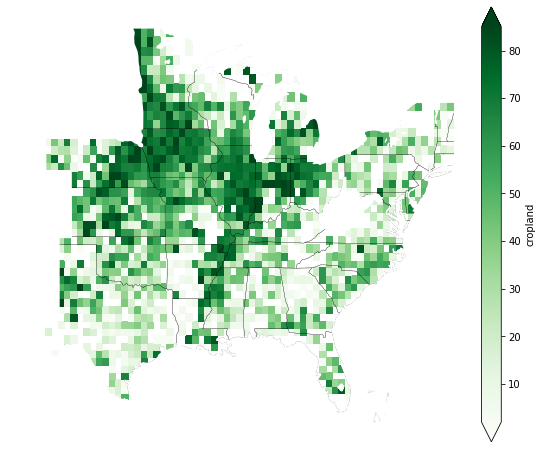

In [14]:
#df_env2 = df_env.assign(useland=lambda x: df_env.cropland > a limit)
df_env3 = df_env.where(df_env.cropland > 0)

#Plotting map with environmental zones
fig, ax = plt.subplots(1, 1, subplot_kw=dict(projection=ccrs.Mercator(central_longitude=-95)),figsize=(10,8))

cmap_name = 'my_list'
cm = LinearSegmentedColormap.from_list(cmap_name, colors)

p=df_env3.cropland.plot(x='lon', y='lat', transform=ccrs.PlateCarree(central_longitude=0),
robust=True, cmap=mpl.cm.Greens, add_colorbar=True, zorder=1)

def area(ax, iso, clr) :
    shp = shpreader.natural_earth(resolution='10m',category='cultural',name='admin_0_countries')
    reader = shpreader.Reader(shp)
    for n in reader.records() :
        if n.attributes['ADM0_A3'] == iso: 
            ax.add_geometries(n.geometry, ccrs.PlateCarree(), facecolor=clr,
                              alpha = 1.00, linewidth =3, edgecolor = "white",
                              label=n.attributes['ADM0_A3']) 
    return ax

iso3 = ['CAN', 'MEX']

def area2(ax, iso, clr, z) :
    
    shp = shpreader.natural_earth(resolution='110m',category='cultural', name='admin_1_states_provinces_lakes_shp')
    reader = shpreader.Reader(shp)
    for n in reader.records() :
        if n.attributes['postal'] == iso: 
            try:
                ax.add_geometries(n.geometry, ccrs.PlateCarree(), facecolor=clr, zorder=z,
                                  alpha = 1.00, linewidth =2, edgecolor = "white",
                                  label=n.attributes['postal']) 
            except Exception as e:
                #print(e)
                import shapely.wkt as wkt
                from shapely.geometry import MultiPolygon
                list_str_polygons = [str(n.geometry)]
                c = MultiPolygon(map(wkt.loads, list_str_polygons))
                ax.add_geometries(c, ccrs.PlateCarree(), facecolor=clr,
                                  alpha = 1.00, linewidth =2, edgecolor = "white",
                                  label=n.attributes['postal']) 
    return ax

iso4 = ['NM','CO','WY','ND','SD', 'WV', 'MT']

gl=ax.gridlines(crs=ccrs.PlateCarree(), linewidth=0.01, color='w', alpha=0, linestyle='-', 
                draw_labels=False,dms=True, x_inline=False, y_inline=False)
#ax.coastlines(color='k',linewidth=0.3, zorder=4)
ax.add_feature(cfeature.COASTLINE, edgecolor = "grey", linewidth=1)
ax.add_feature(cfeature.STATES, edgecolor = "k", linewidth=0.2, zorder=1)
ax.add_feature(cfeature.OCEAN, color='white', zorder=2)
ax.add_feature(cfeature.LAKES, color='white', zorder=1.5)
ax.add_feature(cfeature.BORDERS, edgecolor = "grey", color='grey', linewidth=1)
ax.set_extent([-107, -72, 24.5, 49], crs=ccrs.PlateCarree())
gl.xlabels_top = False
gl.ylabels_right = False

gl.xlocator = mticker.FixedLocator([-100, -90, -80])
gl.ylocator = mticker.FixedLocator([30, 35,40, 45])
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlabel_style = {'size': 10, 'color': 'k'}
gl.ylabel_style = {'size': 10, 'color': 'k'}

for value in iso4 :
    area2(ax, value, "white", 4)

area2(ax, value, "white", 4)

for value in iso3 :
    area(ax, value, "white")

area(ax, value, "white")

ax.outline_patch.set_visible(False)

#plt.savefig(r'C:\Users\uqjojeda\Nextcloud\PURTERRA-A0131\2020\paper\figs\cropland10.png', dpi=600, bbox_inches='tight', pad_inches=0)
hide_toggle()

In [15]:
#Merge dataframes to integrate the environment column with other variables
new = pd.merge(X, df00, how ='inner', on =['lat','lon'], suffixes=['_x','']) 
new2=new.drop([ 'rain_a_x', 'radn_a_x', 'rain_b_x', 'radn_b_x', 'rain_c_x', 'radn_c_x', 'wind_a_x',
 'hur_a_x', 'hurtmax_a_x', 'cropland_a_x', 'tmax_a_x', 'tmin_a_x', 'tmean_a_x', 'wind_b_x', 'hur_b_x',
 'hurtmax_b_x', 'cropland_b_x', 'tmax_b_x', 'tmin_b_x', 'tmean_b_x', 'wind_c_x', 'hur_c_x', 'hurtmax_c_x',
 'cropland_c_x', 'tmax_c_x', 'tmin_c_x', 'tmean_c_x', 'radn_x', 'rain_x', 'tmin_x', 'tmax_x', 'tmean_x',
 'wind_x', 'hur_x', 'hurtmax_x', 'cropland_x', 'irr_x', 'cultivar_x', 'time_x', 'DOY_x', 'DaysAfterSowing_x',
 'ESW1av_x', 'FloweringDAS_x', 'IrrigationIn_x', 'LeafNo_x', 'MaxLAI_x', 'N_stress_expan_x', 'N_stress_photo_x',
 'PAWC_x', 'RadiationIn_x', 'RainIn_x', 'TempIn_x', 'WU_x', 'aMaxT_x', 'aMinT_x', 'actual_ET_x', 'biomass_x',
 'planting_date_x', 'potential_ET_x', 'rad40DAS_x', 'rad80DAS_x', 'radHarv_x', 'rain40DAS_x', 'rain80DAS_x',
 'rainHarv_x', 'ri0_40_x', 'ri40_80_x', 'ri80_harv_x', 'scen_x', 'sw0_40_x', 'sw40_80_x', 'sw80_harv_x',
 'sw_stress_expan_x', 'sw_stress_photo_x', 'temp40DAS_x', 'temp80DAS_x', 'tempHarv_x', 'tp0_40_x', 'tp40_80_x', 'tp80_harv_x'], axis=1)
new2.rename(columns={'biomass_y':'biomass'}, inplace=True)

#Change name of environments accordingly with levels of rad, rain and temp

new2.loc[new2.irr == 1, 'irr_name'] = "rainfed"
new2.loc[new2.irr == 2, 'irr_name'] = "irrigated"

new2.loc[new2.cultivar == 0, 'cv'] = "GS"
new2.loc[new2.cultivar == 1, 'cv'] = "SS"
new2.loc[new2.cultivar == 2, 'cv'] = "FSPS"
new2.loc[new2.cultivar == 3, 'cv'] = "FS"

#Calculate means before the plot
mean=new2.groupby(['env_name','irr_name'])[['biomass']].mean().round(decimals=0)

a=new2.groupby(['env_name','irr_name','cultivar','lat','lon'])[['biomass']].mean().round(decimals=0)

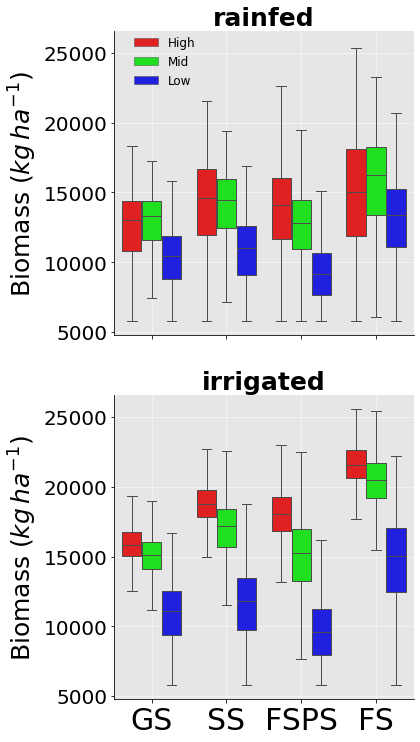

In [16]:
#Plot biomass by environment, cultivar and irrigation management
color_dict = dict({'High': '#ff0101','Mid':'#00ff01','Low':'#0000fe'})

tkt_plot_detailed =sns.catplot(x="cv", order=['GS','SS','FSPS','FS'], y="biomass", data=new2, hue='env_name', 
                               hue_order=['High','Mid','Low'], linewidth=1, kind='box', col='irr_name', 
                               col_wrap=1, legend=False, showfliers = False, palette=color_dict)

tkt_plot_detailed.set_axis_labels("", "Biomass ($kg\,ha^{-1}$)",fontsize= 25)
tkt_plot_detailed.set_titles(col_template="{col_name}", fontweight='bold', size=25)

for ax in tkt_plot_detailed.axes.flatten():

    ax.grid(True, 'major', color='w', linestyle='-', linewidth=0.5)
    ax.grid(True, 'minor', color='0.92', linestyle='-', linewidth=0.7)
    ax.patch.set_facecolor('0.90')
    ax.set_axisbelow(True)
    ax.yaxis.set_tick_params(labelsize=20)
    ax.xaxis.set_tick_params(labelsize=30)
    ax.set_xticklabels(ax.get_xticklabels(),rotation=0)
    pos   = [0, 1, 2, 3]
    label = ['GS','SS','FSPS','FS']
    ax.set_xticks(pos)
    ax.set_xticklabels(label)

plt.legend(prop=dict(size=12),bbox_to_anchor=(0.05, 2.2), loc=2, borderaxespad=0., frameon=False)
plt.subplots_adjust(wspace=0.2, hspace=0.2)
#plt.savefig(r'C:\Users\uqjojeda\Nextcloud\PURTERRA-A0131\2020\paper\figs\envs.png', dpi=300,bbox_inches='tight')
hide_toggle()

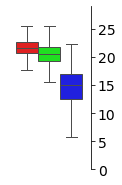

In [26]:
#Create subset of dataframes to create singular plots for biomass
new2['biomass2']=new2['biomass']/1000

rainfed = new2.where(new2['irr_name'] == 'rainfed')
irrigated = new2.where(new2['irr_name'] == 'irrigated')

GSd = rainfed.where(rainfed['cv'] == 'GS')
SSd = rainfed.where(rainfed['cv'] == 'SS')
FSPSd = rainfed.where(rainfed['cv'] == 'FSPS')
FSd = rainfed.where(rainfed['cv'] == 'FS')

GSi = irrigated.where(irrigated['cv'] == 'GS')
SSi = irrigated.where(irrigated['cv'] == 'SS')
FSPSi = irrigated.where(irrigated['cv'] == 'FSPS')
FSi = irrigated.where(irrigated['cv'] == 'FS')

#Plot biomass by environment, cultivar and irrigation management

fig = plt.figure(figsize=(1.5,3))
color_dict = dict({'High': '#ff0101','Mid':'#00ff01','Low':'#0000fe'})
ax=sns.boxplot(x="cv", y="biomass2", data=FSi, hue='env_name', hue_order=['High','Mid','Low'], linewidth=1, showfliers = False, palette=color_dict)
plt.ylabel('', fontsize =13)
plt.xlabel('', fontsize =13)
ax.yaxis.tick_right()
ax.yaxis.set_label_position("right")
ax.yaxis.set_tick_params(labelsize=14, rotation=0)
ax.yaxis.set_major_locator(ticker.MultipleLocator(5))
ax.yaxis.set_major_formatter(ticker.ScalarFormatter())
plt.tick_params(axis='x',bottom=False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.axes.get_xaxis().set_visible(False)
ax.get_legend().remove()
ax.set_ylim([0,29])

fig.savefig(r'C:\Users\uqjojeda\Nextcloud\PURTERRA-A0131\2020\paper\figs\env1.png', dpi=300,bbox_inches='tight',transparent=True)

In [ ]:
#Saving xarray as nc file
#df_env.to_netcdf(r"C:\Users\uqjojeda\Nextcloud\PURTERRA-A0131\2020\paper\data\env.nc")